# Laboratoire 4 : Développement d'un système intelligent
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | Alexandre Bleau — BLEA14058906 / David Létinaud  — LETD05129708 / Thomas Lioret   — LIOT20069605|
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2019                                            |
| Groupe                | 1                                                       |
| Numéro du laboratoire | 4                                                       |
| Professeur            | Prof. LOMBAERT                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 18/12/2019                                              |

In [1]:
import numpy as np

## Introduction et revue de la littérature





Pour choisir correctement les modèles à associés aux ensembles de features, il est important d'étudier ce qui a déjà été fait.
Ainsi, on s'est notamment appuyé sur l'étude "FACILITATING COMPREHENSIVE BENCHMARKING EXPERIMENTS
ON THE MILLION SONG DATASET" réalisée par l'ISMIR (International Society for Music Information Retrieval) en 2012.

La combinaison la plus performante a permis d'obtenir une précision de 27,41 % en appliquant un modèle SVM sur l'ensemble de features "Statistical Spectrum Descriptor"(SSD). Sur ces caractéristiques, l'algorithme KNN a produit une précision comparable de 27,07 %. Les autres modèles testés, baïes naïf, l'arbre de décision et "random forest" ont tous donné un taux d'exactitude entre 14 et 20 % environ. Outre le SSD, d'autres ensembles ont également fait l'objet d'essais, mais tous ont donné des résultats d'une précision inférieur, à une près. 
Les ensembles "MFCC" et "Spectral Derivates" offrent tout de même des performances comparables bien qu'inférieures à celle que peut offrir SSD.

Toutefois, cette étude n'analyse pas les performances que peut offrir un réseau de neurones. En effet, ce modèle de classification n'était pas encore très développé. On a tout de même trouvé une étude plus récente sur la classification de genre de musique. Celle-ci utilise une autre base de donnée appelée : "Free Music Archive" (FMA) constitué de 161 genres. Cette étude, "FMA: A DATASET FOR MUSIC ANALYS" est disponible ici : harxiv.org/pdf/1612.01840.pdf. Bien que le dataset soit différent, il est intéressant de noter que le modèle MLP ("MultiLayer Perceptron") performe très bien avec l'ensemble de features MFCC. Il atteint même une précision de 53%, ce qui en fait pottentiellement un très bon candidat pour notre dataset.

Ainsi, par la suite, nous étudierons 3 modèles qui semblent être les plus performants : MLP (MultiLayer Perceptron), SVM (Support Vector Machine) et RF (Random Forest). Notons que nous préferons pas utilisé KNN puisque celui-ci est très long à entrainer pour des problème de grandes dimensions.

## Exploration des datasets

En premier, il peut être intéressant d'analyser les datasets disponibles. Cela nous permettra par la suite de faire des choix plus éclairés et pourra mieux expliquer les résultats obtenus.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dataset_path_tab = []
dataset_path_tab.append("./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirspectral_dev/msd-jmirspectral_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirderivatives_dev/msd-jmirderivatives_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirlpc_dev/msd-jmirlpc_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmoments_dev/msd-jmirmoments_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-mvd_dev/msd-mvd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-rh_dev_new/msd-rh_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-trh_dev/msd-trh_dev.csv")

On peut d'abord étudier le balancement de chacune des classes des datasets.

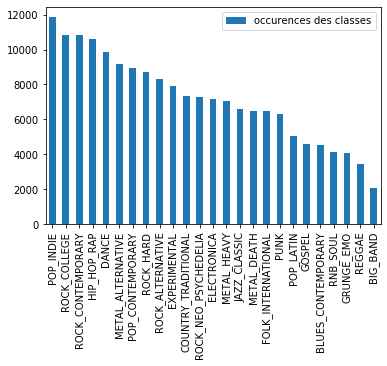

In [4]:
features_list = pd.read_csv(dataset_path_tab[0], header=None, sep = ',')
Y = features_list.iloc[:,-1]
df = pd.DataFrame(Y.value_counts())
ax = df.plot(kind='bar')
ax.legend(["occurences des classes"]);

Cette analyse nous montre que la plupart des classes apparaissent environ 7000 fois. Le dataset n'est toutefois pas balancé puisque le nombre d'occurences des classes peut varier entre 2000 et 12000. C'est une caractéristique du dataset qu'il faudra prendre en compte par la suite.

[168, 26, 16, 96, 20, 10, 124, 420, 60, 420]


Text(0.5, 1.0, 'Number of features per dataset')

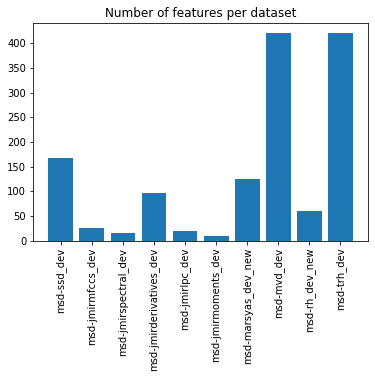

In [5]:
nb_features = []
dataset_path_label = []
for dataset_path in dataset_path_tab:
    features_list = pd.read_csv(dataset_path, header=None, sep = ',', nrows=1)
    nb_features.append(len(features_list.iloc[0,2:-1]))
    dataset_path_label.append(dataset_path.split('/')[2])
    
print(nb_features)
plt.bar(dataset_path_label,nb_features )
plt.xticks(dataset_path_label, rotation='vertical')
plt.title("Number of features per dataset")

Ainsi, on peut remarquer que le nombre de features varie beaucoup en fonction du dataset utilisé. Le nombre de features est particulièrement élevé avec les datasets MVD et TRH. Ces informations sont très utiles pour déterminer s'il est nécessaire de réduire ce nombre avec un algorithme d'analyse en composantes principales (PCA) par exemple.

## Question 2

Comme expliqué précedemment, le modèle MLP est un bon candidat. Toutefois, nous n'avons pas de données sur sa performance avec les ensembles de features du dataset MSD. Nous allons donc créé un modèle MLP est le tester sur tout les ensembles de features disponible pour comparer ses performances. Nous irons plus en détails dans l'ajustement des hyperparamètres par la suite.  
### Validation
Nous utiliserons ici une méthode validation hold-out avec 80% du dataset comme données d'entrainement et 20% en tant que données de tests. Nous utilisons cette méthode de validation pour le choix du partitionnement puisqu'elle à l'avantage d'être plus rapide que la validation croisée.
### Prétraitement
Par ailleurs, on utilise l'option "stratify" de la fonction train_test_split pour que les proportions de chacune des classes soit égale dans le dataset d'entrainement et de celui de test.
On normalise aussi indépendemment chaque features par rapport à la valeur maximale dans le dataset.

#### CLASS_WEIGHTS????

### Configuration de l'environnement
Ici le programme à été exécuté sur une machine ayant les caractéristiques suivantes :

### Partitionnement des données
Pour déterminer au mieux le partitionnement des données, nous testons les performances de chaque modèle choisi avec chaque ensemble de features. Nous irons plus en détails dans l'ajustement des hyperparamètres des modèles par la suite.

In [9]:
from RN_model import RN_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
import shutil
import time
import numpy as np
from functions import get_data, plot_perf_epochs,plot_perf_delay,plot_analyse_grille
import pickle


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
dataset_path_tab = []
dataset_path_tab.append("./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirspectral_dev/msd-jmirspectral_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirderivatives_dev/msd-jmirderivatives_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirlpc_dev/msd-jmirlpc_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmoments_dev/msd-jmirmoments_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-mvd_dev/msd-mvd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-rh_dev_new/msd-rh_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-trh_dev/msd-trh_dev.csv")

In [5]:
path_SSD = "./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv"      
path_marsyas = "./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv"
path_MFC = "./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv" 

In [8]:
# MLP hyperparamaters
layer_sizes = [500]
epochs = 50
learning_rate = 0.0005
batch_size = 500

dropout = 0.5

In [9]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0
f1_RN = []
acc_RN = []

In [10]:
try:      
    shutil.rmtree('./logs')
except:
    print("nothing to delete")
# Callbacks pour affichage des performances dans tensorboard : callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(len(dataset_path_tab)):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006

In [12]:
cpt = 0
for path_ in dataset_path_tab:
    # Get data / normalize it / split into train&test
    X, Y,_,le = get_data(path_)
    X = preprocessing.normalize(X, norm='max',axis = 0)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8,random_state=60, stratify=Y)  # 80% training and 20% test

    # Calcul du nombres de features/classes et taille du dataset
    nb_features = len(X[0])
    nb_classes = max(Y)+1
    train_size = len(X)

    model = RN_model(layer_sizes, dropout, learning_rate, nb_features, nb_classes)
    
    #### Apprentissage                                                                                                                                                               
    start = time.time()                                                                                                                   
    hist_obj = model.fit(X_train[0:train_size], Y_train[0:train_size], batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]]) 
    end = time.time()
    training_delay_RN.append(end - start)
    
    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction                                                                                                                                                                  
    start = time.time()
    Y_pred_temp = model.predict(X_test)
    end = time.time()
    predicting_delay_RN.append(end - start)

    # Remise en forme de Y_pred
    Y_pred = []
    for i in Y_pred_temp:
        Y_pred.append(np.argmax(i)) 
    
    f1 = metrics.f1_score(Y_test, Y_pred,average='weighted')
    acc = metrics.accuracy_score(Y_test, Y_pred)
    print("acc :", acc,"f1 :", f1)
    
    f1_RN.append(f1)
    acc_RN.append(acc)
    cpt+=1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 5s 38us/sample - loss: 2.7907 - acc: 0.1612 - val_loss: 2.6007 - val_acc: 0.2115
Epoch 2/50
143500/143644 [============================>.] - ETA: 0s - loss: 2.5838 - acc: 0.2124

KeyboardInterrupt: 

In [13]:
# Mise en forme des données pour l'affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)  

# Pour affichage
sub_title = ['loss','acc','val_loss','val_acc']
x_lab = "epochs"
leg = [str(i) for i in range(len(direct_path_tab))]  
titre = "RN : Dataset test"                                                                                                                                         

plot_perf_epochs(ho, leg, titre ,sub_title)
plot_perf_delay(f1_RN,acc_RN,training_delay_RN,predicting_delay_RN,titre)

ValueError: axes don't match array

On remarque que le réseau de neurones performe mieux pour les dataset 0, 3 et 6, c'est à dire avec les ensemble de features : SSD, derivates et maryas.

Pour faire un choix éclairé, on réalise des tests similaires pour les 2 autres modèles choisis.

In [6]:
SMV Recherche des hyper paramètres

SyntaxError: invalid syntax (<ipython-input-6-40531a0ba49b>, line 1)

In [10]:
from SVC_model import PCA_Find_ncomp,PCA_transform,SVM_Gridsearch,SVC_Linear,SVC_rbf

In [11]:


X_ssd, Y_ssd,id_ssd, le_ssd= get_data(path_SSD)
X_ssd = preprocessing.normalize(X_ssd, norm='max',axis = 0)
X_train_ssd, X_test_ssd, Y_train_ssd, Y_test_ssd = train_test_split(X_ssd, Y_ssd, train_size=0.8, random_state=60, stratify=Y_ssd)

X_mfcc, Y_mfcc,id_mfcc,le_mfcc = get_data(path_MFC)
X_mfcc= preprocessing.normalize(X_mfcc, norm='max',axis = 0)
X_train_mfcc, X_test_mfcc, Y_train_mfcc, Y_test_mfcc = train_test_split(X_mfcc, Y_mfcc, train_size=0.8, random_state=60, stratify=Y_mfcc)

X_marsyas, Y_marsyas,id_marsyas,le_marsyas = get_data(path_marsyas)
X_marsyas = preprocessing.normalize(X_marsyas, norm='max',axis = 0)
X_train_Marsyas, X_test_Marsyas, Y_train_Marsyas, Y_test_Marsyas = train_test_split(X_marsyas, Y_marsyas, train_size=0.8, random_state=60, stratify=Y_marsyas)

SSD




In [6]:

N_comp=PCA_Find_ncomp(X_train_ssd,0.95)
print(N_comp)
PCA_X_Train_ssd,PCA_X_Test_ssd=PCA_transform(X_train_ssd,X_test_ssd,N_comp)

Grid_ssd = SVM_Gridsearch(PCA_X_Train_ssd[:30000], Y_train_ssd[:30000])

print('best param')
print(Grid_ssd.best_params_)


print('best score')
print(Grid_ssd.best_score_)



28
best param
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
best score
0.2582333333333333


In [ ]:
MFCC

In [8]:

Grid_mfcc = SVM_Gridsearch(X_train_mfcc[:30000], Y_train_mfcc[:30000])

print('best param')
print(Grid_mfcc.best_params_)


print('best score')
print(Grid_mfcc.best_score_)




Test ACC mfccs
best param
{'C': 10, 'gamma': 10, 'kernel': 'rbf'}
best score
0.23176666666666668


In [ ]:
Marsyas

In [12]:



N_comp=PCA_Find_ncomp(X_train_Marsyas,0.999)
print(N_comp)
PCA_X_Train_marsyas,PCA_X_Test_marsyas=PCA_transform(X_train_Marsyas,X_test_Marsyas,N_comp)
Grid_marsyas = SVM_Gridsearch(PCA_X_Train_marsyas[:30000], Y_train_Marsyas[:30000])

print('best param')
print(Grid_marsyas.best_params_)


print('best score')
print(Grid_marsyas.best_score_)




32
best param
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
best score
0.252


Random forest

In [6]:
from RF_model import *
from sklearn import preprocessing

In [7]:
path_list = [path_SSD,path_marsyas,path_MFC]
RF_dataset_study(path_list,n_estimators = 100,n_splits = 5)

./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv
./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv
./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv


[('./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv',
  [0.2786332878505193, 0.2579622595946236]),
 ('./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv',
  [0.28418590404054467, 0.2653304908212962]),
 ('./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv',
  [0.26242098521344437, 0.24163079648736585])]

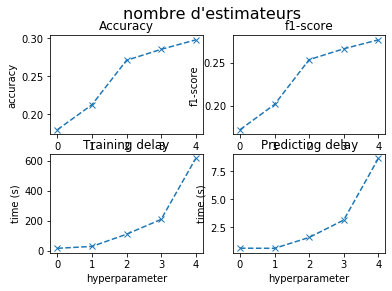

[[1.79994988e-01 1.71992011e-01 1.56976249e+01 6.06432438e-01]
 [2.12603381e-01 2.01375599e-01 2.82406468e+01 5.95977545e-01]
 [2.70774971e-01 2.53553900e-01 1.09497725e+02 1.56730866e+00]
 [2.85076996e-01 2.66202427e-01 2.08493092e+02 3.12533784e+00]
 [2.97507727e-01 2.76608749e-01 6.14609903e+02 8.63623714e+00]]


In [12]:
X,Y,_,le = get_data(path_marsyas)
X = preprocessing.normalize(X, norm ='max',axis=0)
list_estimators = [5,10,50,100,300]
n_splits = 5
res = RF_nbEstimators(X,Y,list_estimators,n_splits)
acc = res[:,0]
f1 = res[:,1]
train_delay = res[:,2]
test_delay = res[:,3]

plot_perf_delay(acc, f1, train_delay,test_delay,"nombre d'estimateurs")
print(res)

/home/ens/AN03460/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ens/AN03460/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ens/AN03460/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ens/AN03460/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ens/AN03460/venv/lib/p

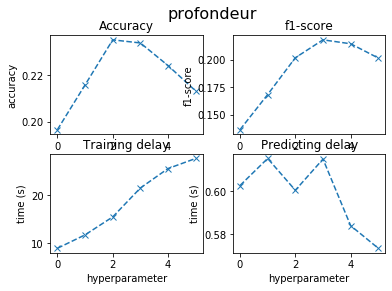

[[ 0.19652474  0.13655648  8.97028661  0.60258651]
 [ 0.21569436  0.16835747 11.75577331  0.61511612]
 [ 0.23502548  0.20166612 15.47586226  0.60040498]
 [ 0.23369441  0.21785416 21.47502947  0.61481953]
 [ 0.22400379  0.21431719 25.51142168  0.58402514]
 [ 0.21311019  0.20137497 27.60271931  0.57355666]]


In [13]:
#Profondeur des arbres
list_max_depth = [5,7,10,15,20,None]
res = RF_maxDepth(X,Y,list_max_depth,n_splits = 5)

acc = res[:,0]
f1 = res[:,1]
train_delay = res[:,2]
test_delay = res[:,3]

plot_perf_delay(acc, f1, train_delay,test_delay,"profondeur")
print(res)

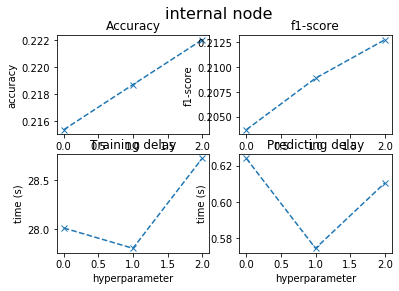

[[ 0.2153769   0.20370326 28.01431918  0.62398124]
 [ 0.2187185   0.20889096 27.80772543  0.57437062]
 [ 0.22204339  0.21275495 28.7219255   0.61038327]]


In [14]:
list_min_samples_splits = [2,3,4]
res = RF_sampleSplit(X,Y,list_min_samples_splits,n_splits = 5)
acc = res[:,0]
f1 = res[:,1]
train_delay = res[:,2]
test_delay = res[:,3]

plot_perf_delay(acc, f1, train_delay,test_delay,"internal node")
print(res)

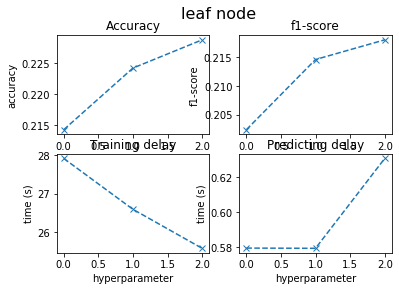

[[ 0.21431873  0.20234372 27.90782213  0.57955241]
 [ 0.22424884  0.21463875 26.59464383  0.57942319]
 [ 0.22879898  0.21808199 25.58701277  0.63085151]]


In [15]:
#Séparation noeud terminal
list_min_samples_leaf = [1,2,3]
res = RF_sampleLeaf(X,Y,list_min_samples_leaf,n_splits = 5)
acc = res[:,0]
f1 = res[:,1]
train_delay = res[:,2]
test_delay = res[:,3]

plot_perf_delay(acc, f1, train_delay,test_delay,"leaf node")
print(res)

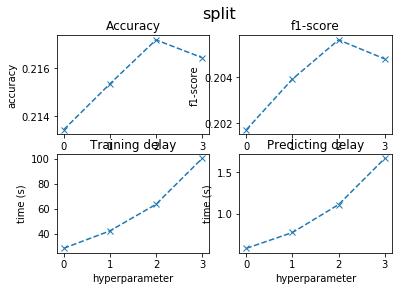

[[  0.21344435   0.20171791  28.33163691   0.58723044]
 [  0.21534908   0.20393139  42.22997546   0.77637005]
 [  0.21718139   0.20564392  63.47508216   1.11025786]
 [  0.21644064   0.20481155 100.12316465   1.66209054]]


In [16]:
#Meilleur K-fold cross validation
list_nb_Ksplit = [5,7,10,15]
res = RF_Kfold_Split(X,Y,list_nb_Ksplit)
acc = res[:,0]
f1 = res[:,1]
train_delay = res[:,2]
test_delay = res[:,3]

plot_perf_delay(acc, f1, train_delay,test_delay,"split")
print(res)

In [7]:
#renseigner les hyper paramètres maximisant les performances :
n_estimators = 300
max_depth=15
min_samples_split=4
min_samples_leaf=3



In [35]:
#Marsyas
# Fit the model on training set
X,Y,_,le = get_data(path_marsyas)
X = preprocessing.normalize(X, norm ='max',axis=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
rfc = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,n_jobs=10,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
rfc.fit(X_train,Y_train)

# save the model to disk
pickle.dump(rfc, open('rfc_marsyas.sav', 'wb'))
loaded_model = pickle.load(open('rfc_marsyas.sav', 'rb'))



In [36]:
#path_SSD
X,Y,_,le = get_data(path_SSD)
X = preprocessing.normalize(X, norm ='max',axis=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
rfc = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,n_jobs=10,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
rfc.fit(X_train, Y_train)

# save the model to disk
pickle.dump(rfc, open('rfc_ssd.sav', 'wb'))
loaded_model = pickle.load(open('rfc_ssd.sav', 'rb'))


In [37]:
#path_MFC
X,Y,_,le = get_data(path_MFC)
X = preprocessing.normalize(X, norm ='max',axis=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
rfc = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,n_jobs=10,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
rfc.fit(X_train, Y_train)

# save the model to disk
pickle.dump(rfc, open('rfc_mfcc.sav', 'wb'))
loaded_model = pickle.load(open('rfc_mfcc.sav', 'rb'))




## Question 3
### Description des modèles et justifications


#### Etudes des hyperparamètres? complète avec tous les tests????????????????????????

## Question 4

### Matrice des expérimentations

### QU'est ce que c'est????????????????????????????????????
Matrices des performances?? accuracy/F1-scores pk "matrice"


### matrices de confusion!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
=> pas lisible du tout!!!!!!!!

### Matrice des résultats de l'étude des hyperparamètres
### QU'est ce que c'est????????????????????????????????????

### Graphiques

Comme pour le TP précédent, on peut étudier le modèle MLP selon les hyperparamètres suivant : 
  . Nombre de couches cachées
  . Nombre de perceptrons sur la couche cachée
  . Taux d'apprentissage
  . Nombre d'epochs

In [1]:
from RN_hyperparam import *

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
layer_size_test()

nothing to delete
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 2s 14us/sample - loss: 2.7918 - acc: 0.1609 - val_loss: 2.5988 - val_acc: 0.2093
Epoch 2/50
143644/143644 [==============================] - 1s 10us/sample - loss: 2.5843 - acc: 0.2108 - val_loss: 2.5228 - val_acc: 0.2320
Epoch 3/50
143644/143644 [==============================] - 1s 10us/sample - loss: 2.5247 - acc: 0.2288 - val_loss: 2.4808 - val_acc: 0.2455
Epoch 4/50
143644/143644 [==============================] - 1s 10us/sample - loss: 2.4885 - acc: 0.2391 - val_loss: 2.4534 - val_acc: 0.2504
Epoch 5/50
143644/143644 [==============================] - 1s 10us/sample - loss: 2.4626 - acc: 0.2475 - val_loss: 2.4307 - val_acc: 0.2562
Epoch 6/50
143644/143644 [=============

Epoch 3/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.5379 - acc: 0.2247 - val_loss: 2.4644 - val_acc: 0.2447
Epoch 4/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.5002 - acc: 0.2352 - val_loss: 2.4350 - val_acc: 0.2566
Epoch 5/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.4728 - acc: 0.2436 - val_loss: 2.4058 - val_acc: 0.2626
Epoch 6/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.4519 - acc: 0.2497 - val_loss: 2.3909 - val_acc: 0.2682
Epoch 7/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.4347 - acc: 0.2557 - val_loss: 2.3739 - val_acc: 0.2739
Epoch 8/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.4236 - acc: 0.2585 - val_loss: 2.3686 - val_acc: 0.2744
Epoch 9/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.4119 - acc: 0.2628 - val_loss: 2.3705 - val_acc: 0.2725
Epoch 10/50
1

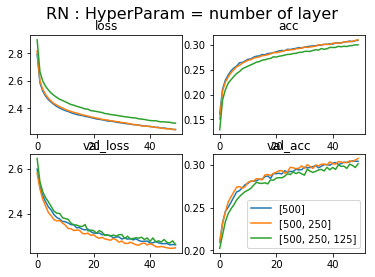

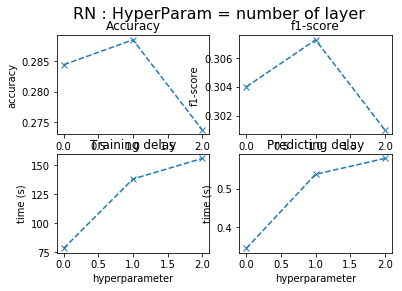

In [3]:
RN_plot_test()

In [4]:
perceptrons_number_test()

nothing to delete
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 1s 7us/sample - loss: 2.9272 - acc: 0.1284 - val_loss: 2.6918 - val_acc: 0.1921
Epoch 2/50
143644/143644 [==============================] - 1s 6us/sample - loss: 2.6941 - acc: 0.1823 - val_loss: 2.5878 - val_acc: 0.2144
Epoch 3/50
143644/143644 [==============================] - 1s 6us/sample - loss: 2.6266 - acc: 0.2019 - val_loss: 2.5465 - val_acc: 0.2265
Epoch 4/50
143644/143644 [==============================] - 1s 6us/sample - loss: 2.5894 - acc: 0.2127 - val_loss: 2.5180 - val_acc: 0.2346
Epoch 5/50
143644/143644 [==============================] - 1s 7us/sample - loss: 2.5658 - acc: 0.2192 - val_loss: 2.5027 - val_acc: 0.2369
Epoch 6/50
143644/143644 [==============================] - 1s 7us/sample - loss: 2.5460 - acc: 0.2252 - val_loss: 2.4821 - val_acc: 0.2428
Epoch 7/50
143644/143644 [==============================] - 1s 7us/sample - loss: 2.5328 - 

Epoch 8/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.4144 - acc: 0.2623 - val_loss: 2.3867 - val_acc: 0.2720
Epoch 9/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.4036 - acc: 0.2656 - val_loss: 2.3855 - val_acc: 0.2708
Epoch 10/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.3936 - acc: 0.2681 - val_loss: 2.3650 - val_acc: 0.2764
Epoch 11/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.3836 - acc: 0.2713 - val_loss: 2.3631 - val_acc: 0.2762
Epoch 12/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.3775 - acc: 0.2722 - val_loss: 2.3539 - val_acc: 0.2799
Epoch 13/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.3705 - acc: 0.2741 - val_loss: 2.3491 - val_acc: 0.2795
Epoch 14/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.3633 - acc: 0.2775 - val_loss: 2.3410 - val_acc: 0.2831
Epoch 15

143644/143644 [==============================] - 2s 17us/sample - loss: 2.3319 - acc: 0.2849 - val_loss: 2.3310 - val_acc: 0.2850
Epoch 16/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.3267 - acc: 0.2861 - val_loss: 2.3184 - val_acc: 0.2876
Epoch 17/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.3202 - acc: 0.2880 - val_loss: 2.3139 - val_acc: 0.2907
Epoch 18/50
143644/143644 [==============================] - 3s 17us/sample - loss: 2.3156 - acc: 0.2901 - val_loss: 2.3118 - val_acc: 0.2911
Epoch 19/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.3078 - acc: 0.2923 - val_loss: 2.3069 - val_acc: 0.2896
Epoch 20/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.3049 - acc: 0.2912 - val_loss: 2.3095 - val_acc: 0.2903
Epoch 21/50
143644/143644 [==============================] - 3s 17us/sample - loss: 2.2998 - acc: 0.2945 - val_loss: 2.2994 - val_acc: 0.2940
Epoch 22/50
143644

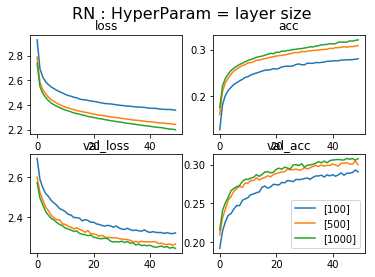

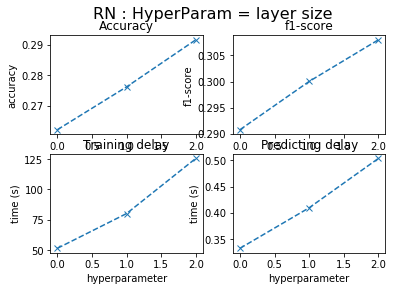

In [5]:
RN_plot_test()

In [6]:
learning_rate_test()

nothing to delete
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 2s 12us/sample - loss: 3.1988 - acc: 0.0633 - val_loss: 3.1686 - val_acc: 0.1024
Epoch 2/50
143644/143644 [==============================] - 2s 10us/sample - loss: 3.1499 - acc: 0.0822 - val_loss: 3.1229 - val_acc: 0.1062
Epoch 3/50
143644/143644 [==============================] - 2s 11us/sample - loss: 3.1091 - acc: 0.0956 - val_loss: 3.0811 - val_acc: 0.1223
Epoch 4/50
143644/143644 [==============================] - 2s 11us/sample - loss: 3.0694 - acc: 0.1092 - val_loss: 3.0372 - val_acc: 0.1341
Epoch 5/50
143644/143644 [==============================] - 2s 11us/sample - loss: 3.0250 - acc: 0.1198 - val_loss: 2.9908 - val_acc: 0.1362
Epoch 6/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.9816 - acc: 0.1279 - val_loss: 2.9458 - val_acc: 0.1439
Epoch 7/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.

/home/ens/AQ38840/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.2178998078583164 f1 : 0.17180858411074612
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 2s 12us/sample - loss: 2.7953 - acc: 0.1605 - val_loss: 2.6072 - val_acc: 0.2075
Epoch 2/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.5916 - acc: 0.2081 - val_loss: 2.5254 - val_acc: 0.2294
Epoch 3/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.5316 - acc: 0.2270 - val_loss: 2.4843 - val_acc: 0.2402
Epoch 4/50
143644/143644 [==============================] - 2s 12us/sample - loss: 2.4930 - acc: 0.2379 - val_loss: 2.4524 - val_acc: 0.2520
Epoch 5/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.4688 - acc: 0.2450 - val_loss: 2.4310 - val_acc: 0.2596
Epoch 6/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.4476 - acc: 0.2522 - val_loss: 2.4134 - val_acc: 0.2639
Epoch 7/50
143644/143644 [===========================

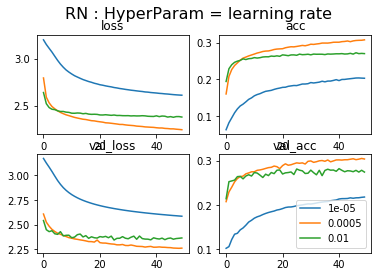

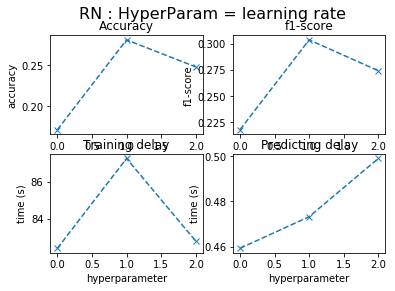

In [7]:
RN_plot_test()

In [8]:
epochs_number_test()

nothing to delete
Train on 143644 samples, validate on 35911 samples
Epoch 1/10
143644/143644 [==============================] - 2s 12us/sample - loss: 2.7921 - acc: 0.1609 - val_loss: 2.6109 - val_acc: 0.2040
Epoch 2/10
143644/143644 [==============================] - 2s 11us/sample - loss: 2.5900 - acc: 0.2105 - val_loss: 2.5302 - val_acc: 0.2325
Epoch 3/10
143644/143644 [==============================] - 2s 11us/sample - loss: 2.5302 - acc: 0.2274 - val_loss: 2.4811 - val_acc: 0.2440
Epoch 4/10
143644/143644 [==============================] - 2s 11us/sample - loss: 2.4926 - acc: 0.2392 - val_loss: 2.4518 - val_acc: 0.2511
Epoch 5/10
143644/143644 [==============================] - 2s 11us/sample - loss: 2.4676 - acc: 0.2471 - val_loss: 2.4283 - val_acc: 0.2583
Epoch 6/10
143644/143644 [==============================] - 2s 11us/sample - loss: 2.4481 - acc: 0.2528 - val_loss: 2.4216 - val_acc: 0.2615
Epoch 7/10
143644/143644 [==============================] - 2s 12us/sample - loss: 2.

143644/143644 [==============================] - 3s 18us/sample - loss: 2.2363 - acc: 0.3105 - val_loss: 2.2518 - val_acc: 0.3059
Epoch 54/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.2355 - acc: 0.3107 - val_loss: 2.2534 - val_acc: 0.3066
Epoch 55/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.2327 - acc: 0.3125 - val_loss: 2.2513 - val_acc: 0.3078
Epoch 56/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.2323 - acc: 0.3112 - val_loss: 2.2561 - val_acc: 0.3073
Epoch 57/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.2289 - acc: 0.3146 - val_loss: 2.2546 - val_acc: 0.3070
Epoch 58/2000
143644/143644 [==============================] - 3s 19us/sample - loss: 2.2276 - acc: 0.3140 - val_loss: 2.2452 - val_acc: 0.3095
Epoch 59/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.2278 - acc: 0.3128 - val_loss: 2.2458 - val_acc: 0.3095
Epoch 

Epoch 110/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1461 - acc: 0.3345 - val_loss: 2.2218 - val_acc: 0.3172
Epoch 111/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1486 - acc: 0.3351 - val_loss: 2.2225 - val_acc: 0.3166
Epoch 112/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1455 - acc: 0.3351 - val_loss: 2.2213 - val_acc: 0.3181
Epoch 113/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1449 - acc: 0.3355 - val_loss: 2.2241 - val_acc: 0.3162
Epoch 114/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1431 - acc: 0.3351 - val_loss: 2.2164 - val_acc: 0.3193
Epoch 115/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1430 - acc: 0.3362 - val_loss: 2.2221 - val_acc: 0.3174
Epoch 116/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1428 - acc: 0.3347 - val_loss: 2.2207 - v

143644/143644 [==============================] - 2s 12us/sample - loss: 2.0419 - acc: 0.3617 - val_loss: 2.2089 - val_acc: 0.3255
Epoch 223/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 2.0434 - acc: 0.3619 - val_loss: 2.2083 - val_acc: 0.3242
Epoch 224/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 2.0393 - acc: 0.3637 - val_loss: 2.2098 - val_acc: 0.3248
Epoch 225/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 2.0396 - acc: 0.3626 - val_loss: 2.2138 - val_acc: 0.3239
Epoch 226/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 2.0370 - acc: 0.3636 - val_loss: 2.2109 - val_acc: 0.3231
Epoch 227/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 2.0380 - acc: 0.3626 - val_loss: 2.2065 - val_acc: 0.3244
Epoch 228/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 2.0364 - acc: 0.3637 - val_loss: 2.2137 - val_acc: 0.3235


143644/143644 [==============================] - 2s 11us/sample - loss: 1.9754 - acc: 0.3784 - val_loss: 2.2229 - val_acc: 0.3233
Epoch 335/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9740 - acc: 0.3799 - val_loss: 2.2210 - val_acc: 0.3260
Epoch 336/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9750 - acc: 0.3792 - val_loss: 2.2242 - val_acc: 0.3260
Epoch 337/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9745 - acc: 0.3794 - val_loss: 2.2341 - val_acc: 0.3252
Epoch 338/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9746 - acc: 0.3792 - val_loss: 2.2288 - val_acc: 0.3236
Epoch 339/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9766 - acc: 0.3790 - val_loss: 2.2209 - val_acc: 0.3257
Epoch 340/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9729 - acc: 0.3805 - val_loss: 2.2268 - val_acc: 0.3252


143644/143644 [==============================] - 2s 11us/sample - loss: 1.9322 - acc: 0.3903 - val_loss: 2.2495 - val_acc: 0.3233
Epoch 447/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9285 - acc: 0.3906 - val_loss: 2.2516 - val_acc: 0.3256
Epoch 448/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9283 - acc: 0.3905 - val_loss: 2.2461 - val_acc: 0.3230
Epoch 449/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9316 - acc: 0.3895 - val_loss: 2.2448 - val_acc: 0.3240
Epoch 450/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9330 - acc: 0.3889 - val_loss: 2.2481 - val_acc: 0.3256
Epoch 451/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9305 - acc: 0.3898 - val_loss: 2.2528 - val_acc: 0.3242
Epoch 452/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9308 - acc: 0.3895 - val_loss: 2.2430 - val_acc: 0.3237


143644/143644 [==============================] - 2s 11us/sample - loss: 1.8990 - acc: 0.3942 - val_loss: 2.2788 - val_acc: 0.3238
Epoch 559/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8977 - acc: 0.3975 - val_loss: 2.2732 - val_acc: 0.3243
Epoch 560/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8991 - acc: 0.3974 - val_loss: 2.2780 - val_acc: 0.3244
Epoch 561/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8991 - acc: 0.3962 - val_loss: 2.2787 - val_acc: 0.3227
Epoch 562/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8954 - acc: 0.3974 - val_loss: 2.2791 - val_acc: 0.3217
Epoch 563/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8987 - acc: 0.3963 - val_loss: 2.2694 - val_acc: 0.3217
Epoch 564/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8973 - acc: 0.3962 - val_loss: 2.2798 - val_acc: 0.3227


143644/143644 [==============================] - 2s 11us/sample - loss: 1.8749 - acc: 0.4011 - val_loss: 2.2987 - val_acc: 0.3207
Epoch 671/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8720 - acc: 0.4040 - val_loss: 2.2998 - val_acc: 0.3193
Epoch 672/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8709 - acc: 0.4033 - val_loss: 2.3041 - val_acc: 0.3228
Epoch 673/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8696 - acc: 0.4027 - val_loss: 2.2971 - val_acc: 0.3213
Epoch 674/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8725 - acc: 0.4017 - val_loss: 2.2987 - val_acc: 0.3213
Epoch 675/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8713 - acc: 0.4018 - val_loss: 2.2950 - val_acc: 0.3217
Epoch 676/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8721 - acc: 0.4032 - val_loss: 2.2953 - val_acc: 0.3237


143644/143644 [==============================] - 3s 18us/sample - loss: 1.8532 - acc: 0.4061 - val_loss: 2.3392 - val_acc: 0.3185
Epoch 783/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8526 - acc: 0.4060 - val_loss: 2.3247 - val_acc: 0.3195
Epoch 784/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8486 - acc: 0.4068 - val_loss: 2.3267 - val_acc: 0.3197
Epoch 785/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8509 - acc: 0.4066 - val_loss: 2.3348 - val_acc: 0.3186
Epoch 786/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8513 - acc: 0.4064 - val_loss: 2.3206 - val_acc: 0.3199
Epoch 787/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8501 - acc: 0.4072 - val_loss: 2.3359 - val_acc: 0.3197
Epoch 788/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8525 - acc: 0.4064 - val_loss: 2.3356 - val_acc: 0.3192


143644/143644 [==============================] - 3s 18us/sample - loss: 1.8327 - acc: 0.4098 - val_loss: 2.3591 - val_acc: 0.3179
Epoch 895/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8356 - acc: 0.4103 - val_loss: 2.3570 - val_acc: 0.3185
Epoch 896/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8363 - acc: 0.4087 - val_loss: 2.3547 - val_acc: 0.3160
Epoch 897/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8323 - acc: 0.4108 - val_loss: 2.3573 - val_acc: 0.3197
Epoch 898/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8359 - acc: 0.4087 - val_loss: 2.3507 - val_acc: 0.3166
Epoch 899/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8355 - acc: 0.4099 - val_loss: 2.3580 - val_acc: 0.3177
Epoch 900/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8337 - acc: 0.4099 - val_loss: 2.3531 - val_acc: 0.3175


143644/143644 [==============================] - 3s 18us/sample - loss: 1.8203 - acc: 0.4131 - val_loss: 2.3633 - val_acc: 0.3163
Epoch 1007/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8188 - acc: 0.4141 - val_loss: 2.3788 - val_acc: 0.3179
Epoch 1008/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8208 - acc: 0.4129 - val_loss: 2.3687 - val_acc: 0.3158
Epoch 1009/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8207 - acc: 0.4123 - val_loss: 2.3793 - val_acc: 0.3155
Epoch 1010/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8185 - acc: 0.4145 - val_loss: 2.3683 - val_acc: 0.3161
Epoch 1011/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8200 - acc: 0.4111 - val_loss: 2.3835 - val_acc: 0.3165
Epoch 1012/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8179 - acc: 0.4131 - val_loss: 2.3816 - val_acc: 0

143644/143644 [==============================] - 3s 17us/sample - loss: 1.8082 - acc: 0.4143 - val_loss: 2.3963 - val_acc: 0.3155
Epoch 1119/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8043 - acc: 0.4171 - val_loss: 2.4150 - val_acc: 0.3151
Epoch 1120/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8076 - acc: 0.4143 - val_loss: 2.4074 - val_acc: 0.3139
Epoch 1121/2000
143644/143644 [==============================] - 3s 19us/sample - loss: 1.8095 - acc: 0.4137 - val_loss: 2.3937 - val_acc: 0.3152
Epoch 1122/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8063 - acc: 0.4157 - val_loss: 2.4042 - val_acc: 0.3168
Epoch 1123/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8090 - acc: 0.4159 - val_loss: 2.4191 - val_acc: 0.3156
Epoch 1124/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8067 - acc: 0.4141 - val_loss: 2.4030 - val_acc: 0

Epoch 1230/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7951 - acc: 0.4168 - val_loss: 2.4224 - val_acc: 0.3138
Epoch 1231/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 1.7964 - acc: 0.4174 - val_loss: 2.4273 - val_acc: 0.3132
Epoch 1232/2000
143644/143644 [==============================] - 2s 15us/sample - loss: 1.7964 - acc: 0.4163 - val_loss: 2.4339 - val_acc: 0.3144
Epoch 1233/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7968 - acc: 0.4167 - val_loss: 2.4351 - val_acc: 0.3111
Epoch 1234/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7955 - acc: 0.4158 - val_loss: 2.4491 - val_acc: 0.3136
Epoch 1235/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7940 - acc: 0.4182 - val_loss: 2.4410 - val_acc: 0.3145
Epoch 1236/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7958 - acc: 0.4167 - val_loss: 2.4

143644/143644 [==============================] - 2s 11us/sample - loss: 1.7846 - acc: 0.4188 - val_loss: 2.4588 - val_acc: 0.3129
Epoch 1343/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7854 - acc: 0.4192 - val_loss: 2.4591 - val_acc: 0.3162
Epoch 1344/2000
143644/143644 [==============================] - 2s 14us/sample - loss: 1.7874 - acc: 0.4175 - val_loss: 2.4663 - val_acc: 0.3134
Epoch 1345/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7889 - acc: 0.4183 - val_loss: 2.4653 - val_acc: 0.3131
Epoch 1346/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7845 - acc: 0.4190 - val_loss: 2.4667 - val_acc: 0.3124
Epoch 1347/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7841 - acc: 0.4184 - val_loss: 2.4587 - val_acc: 0.3131
Epoch 1348/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7859 - acc: 0.4175 - val_loss: 2.4666 - val_acc: 0

143644/143644 [==============================] - 3s 19us/sample - loss: 1.7783 - acc: 0.4192 - val_loss: 2.4786 - val_acc: 0.3142
Epoch 1455/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7741 - acc: 0.4205 - val_loss: 2.4989 - val_acc: 0.3145
Epoch 1456/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7789 - acc: 0.4188 - val_loss: 2.4834 - val_acc: 0.3133
Epoch 1457/2000
143644/143644 [==============================] - 3s 19us/sample - loss: 1.7753 - acc: 0.4194 - val_loss: 2.4984 - val_acc: 0.3130
Epoch 1458/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7756 - acc: 0.4211 - val_loss: 2.4897 - val_acc: 0.3135
Epoch 1459/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7776 - acc: 0.4194 - val_loss: 2.4817 - val_acc: 0.3122
Epoch 1460/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7772 - acc: 0.4210 - val_loss: 2.4994 - val_acc: 0

143644/143644 [==============================] - 2s 12us/sample - loss: 1.7668 - acc: 0.4214 - val_loss: 2.5123 - val_acc: 0.3101
Epoch 1567/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 1.7658 - acc: 0.4227 - val_loss: 2.5084 - val_acc: 0.3126
Epoch 1568/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 1.7701 - acc: 0.4215 - val_loss: 2.5209 - val_acc: 0.3132
Epoch 1569/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 1.7701 - acc: 0.4201 - val_loss: 2.5213 - val_acc: 0.3126
Epoch 1570/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 1.7709 - acc: 0.4218 - val_loss: 2.5119 - val_acc: 0.3132
Epoch 1571/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7690 - acc: 0.4212 - val_loss: 2.5034 - val_acc: 0.3107
Epoch 1572/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7681 - acc: 0.4216 - val_loss: 2.5223 - val_acc: 0

143644/143644 [==============================] - 2s 12us/sample - loss: 1.7601 - acc: 0.4219 - val_loss: 2.5468 - val_acc: 0.3115
Epoch 1679/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 1.7606 - acc: 0.4236 - val_loss: 2.5306 - val_acc: 0.3124
Epoch 1680/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7578 - acc: 0.4240 - val_loss: 2.5442 - val_acc: 0.3117
Epoch 1681/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7629 - acc: 0.4216 - val_loss: 2.5488 - val_acc: 0.3121
Epoch 1682/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7597 - acc: 0.4234 - val_loss: 2.5405 - val_acc: 0.3122
Epoch 1683/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7618 - acc: 0.4223 - val_loss: 2.5430 - val_acc: 0.3106
Epoch 1684/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7597 - acc: 0.4230 - val_loss: 2.5408 - val_acc: 0

143644/143644 [==============================] - 3s 18us/sample - loss: 1.7521 - acc: 0.4237 - val_loss: 2.5706 - val_acc: 0.3115
Epoch 1791/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7511 - acc: 0.4247 - val_loss: 2.5746 - val_acc: 0.3106
Epoch 1792/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7557 - acc: 0.4244 - val_loss: 2.5845 - val_acc: 0.3104
Epoch 1793/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7566 - acc: 0.4222 - val_loss: 2.5731 - val_acc: 0.3110
Epoch 1794/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7556 - acc: 0.4223 - val_loss: 2.5656 - val_acc: 0.3111
Epoch 1795/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7551 - acc: 0.4217 - val_loss: 2.5731 - val_acc: 0.3107
Epoch 1796/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7510 - acc: 0.4242 - val_loss: 2.5792 - val_acc: 0

143644/143644 [==============================] - 2s 11us/sample - loss: 1.7459 - acc: 0.4248 - val_loss: 2.6009 - val_acc: 0.3109
Epoch 1903/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7469 - acc: 0.4262 - val_loss: 2.6055 - val_acc: 0.3115
Epoch 1904/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7470 - acc: 0.4251 - val_loss: 2.6101 - val_acc: 0.3108
Epoch 1905/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7463 - acc: 0.4260 - val_loss: 2.6013 - val_acc: 0.3118
Epoch 1906/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7463 - acc: 0.4267 - val_loss: 2.6093 - val_acc: 0.3095
Epoch 1907/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7490 - acc: 0.4259 - val_loss: 2.6172 - val_acc: 0.3105
Epoch 1908/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7477 - acc: 0.4247 - val_loss: 2.5986 - val_acc: 0

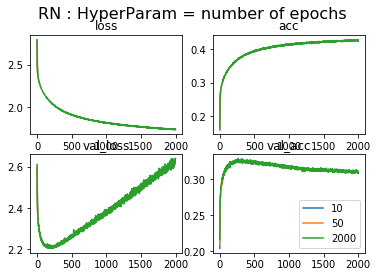

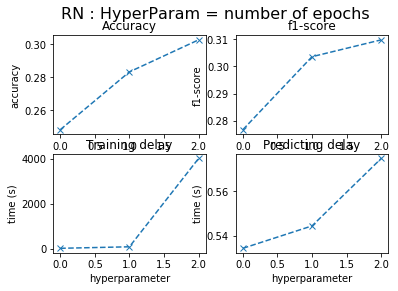

In [9]:
RN_plot_test()

SVM

SSD 


In [7]:
Res = plot_analyse_grille(Grid_ssd)
Res

,param_kernel,param_C,param_gamma,rank_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,mean_test_F1,std_test_F1,mean_fit_time,std_fit_time,mean_score_time,std_score_time
3,linear,10,NaN,4,0.239567,0.001513,0.198350,0.002306,75.276958,3.045932,42.654659,0.726639
2,linear,1,NaN,5,0.233567,0.003655,0.180102,0.003356,56.936417,2.987882,37.577106,1.399274
1,linear,0.1,NaN,10,0.208667,0.004344,0.129805,0.003414,74.488432,3.538897,41.664008,1.521690
0,linear,0.001,NaN,15,0.077867,0.001645,0.016832,0.001058,93.569479,2.837201,43.247254,2.073587
18,rbf,10,1,1,0.258233,0.001646,0.239376,0.002517,85.258407,4.758356,38.810285,0.432130
14,rbf,1,1,2,0.251867,0.002091,0.211311,0.001458,82.479036,9.763499,39.616673,1.979819
17,rbf,10,0.1,3,0.247500,0.001300,0.202255,0.002138,76.607899,1.291135,43.177971,1.290711
15,rbf,1,10,6,0.233433,0.002047,0.203414,0.003388,148.049963,3.180526,45.361381,1.077580
19,rbf,10,10,7,0.225033,0.002338,0.210501,0.003316,146.041194,3.890111,38.040676,0.400997
13,rbf,1,0.1,8,0.222167,0.002705,0.152157,0.003661,92.293865,2.325597,44.439625,0.619502


In [10]:
PCA_X_Train_ssd,PCA_X_Test_ssd=PCA_transform(X_train_ssd,X_test_ssd,28)
Svc_ssd,y_pred_ssd,train_time_ssd,pred_time_ssd=SVC_rbf(PCA_X_Train_ssd, Y_train_ssd, PCA_X_Test_ssd, Y_test_ssd,10,1)
pickle.dump(Svc_ssd,open('svm_ssd.sav','wb'))
loaded_model_ssd =pickle.load(open('svm_ssd.sav','rb'))

#svm_result_ssd=loaded_model_ssd.score(PCA_X_Test_ssd,Y_test_ssd)


[[  83   22   73    2    1    8   22    4    1    6   76    1    0    0
    13   19    6    0    3   12    1    2   41   12    1]
 [  16  280   96   11    6   24   43    6    1   28   62   17    1    4
    11   79   15    4   10   31    6   28   85   36    2]
 [  24   58  597   13    8   34   68   24    2   21   54   19    0    1
    31  120   24    6    6   21   10   39  254   29    0]
 [   0   10   23  889  134   71   38    8    2  270   42   10    9    3
   118   79   27    9   74   25    8   32   75   16    5]
 [   4   14   12  368  277  119   34    6    2  125   72   15   17   10
    38  136   11   10   20    3    8   46   68   13    2]
 [   3   24   57  129  117  300   33    6    2   52   94   39   28   27
    18  254   10   25   10   18   14  111   96  109   10]
 [  16   47  124   69   37   59  241   14    1   62  101   14    3    2
    33  111   69    5   15   15    5   27  191   30    2]
 [   8   11  104   27    6   23   40   79    2   49   33   45    4    5
    64   59   22  

KeyboardInterrupt: 

MFCC

In [9]:
Res = plot_analyse_grille(Grid_mfcc)
Res

,param_kernel,param_C,param_gamma,rank_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,mean_test_F1,std_test_F1,mean_fit_time,std_fit_time,mean_score_time,std_score_time
3,linear,10,NaN,4,0.207633,0.006998,0.148962,0.005971,77.467583,1.244237,42.441112,0.535828
2,linear,1,NaN,8,0.183267,0.004474,0.109586,0.002909,72.399072,3.352113,40.134773,0.755467
1,linear,0.1,NaN,11,0.140633,0.003636,0.051267,0.001342,83.978450,4.055071,41.824511,2.176844
0,linear,0.001,NaN,19,0.066167,0.000172,0.005039,0.000149,91.103970,1.137961,43.699297,1.661258
19,rbf,10,10,1,0.231767,0.004923,0.208334,0.003057,102.164044,1.545297,39.916992,1.026812
18,rbf,10,1,2,0.229333,0.004121,0.182958,0.001794,84.463839,6.903085,39.948914,2.223541
15,rbf,1,10,3,0.224400,0.003703,0.182344,0.004574,93.829787,3.615731,42.418415,1.071368
14,rbf,1,1,5,0.203900,0.004109,0.139144,0.003378,88.334726,10.102054,41.012745,2.898361
17,rbf,10,0.1,6,0.200167,0.003839,0.132808,0.002637,97.805958,1.510949,42.324329,1.643260
11,rbf,0.1,10,7,0.188233,0.005050,0.120870,0.002588,105.870646,2.412541,43.097201,0.919036


In [12]:
Svc_mfcc,y_pred_mfcc,train_time_mfcc,pred_time_mfcc=SVC_rbf(X_train_mfcc, Y_train_mfcc, X_test_mfcc, Y_test_mfcc,10,10)
pickle.dump(Svc_mfcc,open('svm_mfcc.sav','wb'))
loaded_model_mfcc =pickle.load(open('svm_mfcc.sav','rb'))

svm_result_mfcc=loaded_model_mfcc.score(X_test_mfcc,Y_test_mfcc)

[[ 163   25   43    3    5   11   25   11    0    8   36    1    1    1
     7    4   12    2    8   17    1    2   14    8    1]
 [  50  341   80   10   19   18   19   25   10   10   59   12    1    9
     6   24   32   15   22   49    7   16   30   32    6]
 [  94   83  568    5   14   27   59  100   20   14   51    6    4    3
    47   44   78   10   16   58   20   19   94   24    5]
 [  13   42   47  602  210   78   23   58   22  198   39   11   19   22
   120   38   62   17  139   94   28   18   44   15   18]
 [  16   52   27  236  288  120   45   16   20  122   75   18   18   13
    27   60   22   21   62   37   27   47   35   14   12]
 [  39  109   61  100  151  229   60   37   32   31  100   30   51   36
    17   89   39   53   29   53   38   60   41   78   23]
 [  84   81  111   43   48   61  250   74    7   43   89   11    2    9
    29   31  106   10   28   50   16   20   68   18    4]
 [  36   23   66   17   10   16   23  213   23   31   29   26    6    5
    66   10   87  

In [ ]:
MARSYAS


In [13]:
Res = plot_analyse_grille(Grid_marsyas)
Res

,param_kernel,param_C,param_gamma,rank_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,mean_test_F1,std_test_F1,mean_fit_time,std_fit_time,mean_score_time,std_score_time
3,linear,10,NaN,2,0.244867,0.005198,0.204222,0.003818,663.918028,136.190711,33.176671,3.156672
2,linear,1,NaN,3,0.242300,0.004108,0.190484,0.003982,93.029087,2.249934,32.584381,3.697610
1,linear,0.1,NaN,6,0.218867,0.005236,0.145895,0.004680,97.357390,3.438051,47.429911,1.366742
0,linear,0.001,NaN,14,0.116133,0.003440,0.042653,0.001637,105.478564,2.455968,45.460705,2.155211
17,rbf,10,0.1,1,0.252000,0.007806,0.212312,0.006532,84.481729,4.169188,41.091493,0.333232
14,rbf,1,1,4,0.236967,0.006708,0.193606,0.005236,89.292570,4.359314,44.446474,1.897484
18,rbf,10,1,5,0.234267,0.006947,0.220659,0.005258,105.648317,4.792816,44.932414,1.877200
13,rbf,1,0.1,7,0.218767,0.005016,0.151913,0.004659,99.191679,6.764479,44.943599,0.909761
19,rbf,10,10,8,0.189133,0.004954,0.153425,0.006338,135.313102,15.935387,29.813053,2.989915
15,rbf,1,10,9,0.189033,0.005022,0.136915,0.004589,168.469665,8.819141,48.077360,2.323913


In [11]:
PCA_X_Train_marsyas,PCA_X_Test_marsyas=PCA_transform(X_train_Marsyas,X_test_Marsyas,32)
Svc_marsyas,y_pred_marsya,train_time_marsya,pred_time_marsya=SVC_rbf(PCA_X_Train_marsyas, Y_train_Marsyas, PCA_X_Test_marsyas, Y_test_Marsyas,10,0.1)
pickle.dump(Svc_marsyas,open('svm_marsyas.sav','wb'))
loaded_model_marsyas =pickle.load(open('svm_marsyas.sav','rb'))

svm_result_marsyas=loaded_model_marsyas.score(PCA_X_Test_marsyas,Y_test_Marsyas)

[[  61   19   99    2    2   17   12    2    0    2   49    5    0    0
    20   24    7    0    1    8    0    2   67    9    1]
 [   9  243  127    9    5   27   33    0    0   11   92   12    0    3
    13   86   15    4    7   18    0   19  104   60    5]
 [  22   66  625    3    5   26   54    2    0   15   66   26    2    2
    25   99   18    7    5   11    5   32  311   32    4]
 [   2   21   17  881  105   74   19    2    0  265   37   28   12   11
   140  100   23    7   65   14    3   27   90   27    7]
 [   3   16   16  420  227  142   32    0    0  107   83   26   25    4
    38  120    7   11   18    2    4   50   67    9    3]
 [   9   41   49  168  102  224   50    1    1   35  127   50   38   30
    27  244   15   32    8   11    4   83  116  119    2]
 [  18   56  128   75   26   66  221    6    0   40  142   15    3    3
    56   76   91    3   13   11    2   28  179   29    6]
 [  10   12  119   29    3   17   20   13    3   35   36   53    1    8
    91   68   32  


### Discussion

## Question 5
### Présentation de la conception

Nous avons d'abord sauvegardé 9 modèles entrainés pour pouvoir les réutiliser plus tard.

Nous avons utilisé la libraire pickle pour sauvegarder les modèles de scikit learn.
On les sauvegardes de la manière suivante : 

In [5]:
# Persistence avec Sklearn
import pickle
# Save the model
pickle_out = open("SVM.sav", "wb")
pickle.dump(clf,pickle_out)

# Load the model
pickle_in = open("SVM.sav", "rb")
clf2 = pickle.loads(pickle_in)

NameError: name 'model' is not defined

La persistence des modèles fonctionnent un peu différemment avec tensorflow.
Pour cela, il faut créer un callbacks qui sauvegarde les poids du réseau de neurones.
Exemple :

In [ ]:
# Persistence avec tensorflow
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath="Models/MLP_model_SSD/cp.ckpt",
                                   save_weights_only=True,
                                   verbose=1)

Ce callback est ensuite spécifié avec le paramètre callbacks de la fonction fit du model tensorflow du réseau de neurones.
On pourra ensuie charger les poids sauvegardé dans un second modèles, de la manière suivante :

In [ ]:
# Load weigths :
checkpoint_path = "Models/MLP_model_SSD/cp.ckpt"
model2 = RN_model(layer_sizes, dropout, learning_rate, nb_features, nb_classes)
model2.load_weights(checkpoint_path)

## Question 6
### Hyperparamètres des modèles choisis dans la conception


In [8]:
import numpy as np
from functions import plot_confusion_matrix
from voting import voting, voting_L1, write_pred_csv

In [9]:
# liste des classes tel que le ressort le.classes_
classes_ = ['BIG_BAND','BLUES_CONTEMPORARY','COUNTRY_TRADITIONAL','DANCE',
            'ELECTRONICA','EXPERIMENTAL','FOLK_INTERNATIONAL','GOSPEL','GRUNGE_EMO',
            'HIP_HOP_RAP','JAZZ_CLASSIC','METAL_ALTERNATIVE','METAL_DEATH',
            'METAL_HEAVY','POP_CONTEMPORARY','POP_INDIE','POP_LATIN','PUNK','REGGAE',
            'RNB_SOUL','ROCK_ALTERNATIVE','ROCK_COLLEGE','ROCK_CONTEMPORARY',
            'ROCK_HARD','ROCK_NEO_PSYCHEDELIA']

data_path = ["./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv", "./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv", "./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv"] #=> MLP 30.7%
data_path_nolabels = ["./untagged_feature_sets/msd-ssd_test_nolabels/msd-ssd_test_nolabels.csv", "./untagged_feature_sets/msd-jmirmfccs_test_nolabels/msd-jmirmfccs_test_nolabels.csv", "./untagged_feature_sets/msd-marsyas_test_new_nolabels/msd-marsyas_test_new_nolabels.csv"] #=> MLP 30.7%

In [10]:
# Calculer les poids de la couche 1
#           RN    RF  SVM    
SSD_acc = [0.273, 0.21, 0.183]
MFCC_acc = [0.155,0.13,0.117]
MARSYAS_acc = [0.224,0.208,0.167]

weight = []
# Le poids est calculé selon le pourcentage que représente l'accuracy..
# .. du modèle sur la somme total des accuracy sur le dataset étudié
MSSD_total = np.sum(np.array(SSD_acc))
weight.append([a/MSSD_total for a in SSD_acc])
MFCC_total = np.sum(np.array(MFCC_acc))
weight.append([a/MFCC_total for a in MFCC_acc])
MARSYAS_total = np.sum(np.array(MARSYAS_acc))
weight.append([a/MARSYAS_total for a in MARSYAS_acc])
print("Weight L1")
print(weight)

Weight L1
[[0.40990990990991, 0.3153153153153153, 0.2747747747747748], [0.38557213930348255, 0.3233830845771144, 0.291044776119403], [0.3739565943238731, 0.34724540901502504, 0.2787979966611019]]


In [11]:
RN_models_path = ["Models/MLP_model_SSD/cp.ckpt", "Models/MLP_model_MFCC/cp.ckpt", "Models/MLP_model_MARSYAS/cp.ckpt" ]
RF_models_path = ["./Models/rfc_ssd.sav","./Models/rfc_mfcc.sav","./Models/rfc_marsyas.sav"]
SVM_models_path = ["./Models/svm_ssd.sav","./Models/svm_mfcc.sav","./Models/svm_marsyas.sav"]
SVM_N_comp_tab = [28, -1,32]

In [12]:
pred, perf = voting(data_path,weight,RN_models_path, RF_models_path, SVM_models_path,SVM_N_comp_tab,classes_,with_labels=True)

C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
print("Précision : {} | F1-score : {}".format(perf[0], perf[1]))

Précision : 0.04 | F1-score : 0.04245977011494253


Normalized confusion matrix (in %)


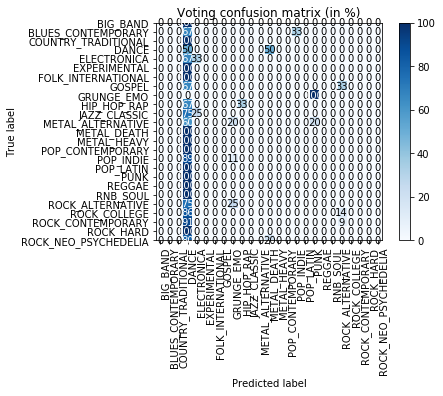

In [14]:
plot_confusion_matrix(pred[3],pred[2],classes_, title="Voting confusion matrix (in %)") # Affichage en % au lieu de normalisation standard pour une meilleure visibilité

Le résultat de la matrice de confusion étant peu lisible de cette façon, nous l'avons enregistrer dans ..

### Matrice des résultats

### Discussion

comparaison entre les modèles prit independemment et les modèles combinés

## Question 7 
### Formulation des recommandations

Faire une étude approfondies des poids...
Réaliser une meilleur gestion du débalacement...
Implémenter une méthode de boosting...

## Conclusion